In [1]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
print(os.getcwd())
#os.chdir('archive/asl_alphabet_train/asl_alphabet_train')
os.listdir()
train_dir = '../jagannathan/ASL_DATA_4K/archive/asl_alphabet_train/asl_alphabet_train/'
test_dir = '../jagannathan/ASL_DATA_4K/archive/asl_alphabet_test/asl_alphabet_test/'

/home/jupyter


In [3]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 75,75
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.to_categorical(labels)
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.05)
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [4]:
X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : S | Y | B | J | G | A | Q | E | V | L | space | F | R | del | C | nothing | U | K | T | P | Z | N | W | I | M | H | D | O | X | 
Loaded 82650 images for training, Train data shape = (82650, 75, 75, 3)
Loaded 4350 images for testing Test data shape = (4350, 75, 75, 3)


In [5]:
from tensorflow.keras.applications import inception_v3

# Init the InceptionV3 model 
inceptionv3 = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

2021-11-24 15:55:35.778405: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2021-11-24 15:55:35.779706: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56520efa7de0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-24 15:55:35.779735: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-24 15:55:35.782321: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
# Freeze all the layers
for layer in inceptionv3.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in inceptionv3.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff69e0cb4d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff68f845750> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff68f8455d0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7ff68fafead0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff68f015d50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff68c54ddd0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7ff68f015490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff68fad3e10> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff68c4ffe50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7ff68c52d490> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff68fad3690> False
<tensorflow.python.keras.layers.c

In [7]:
# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(inceptionv3)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(29, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                29725     
Total params: 23,930,685
Trainable params: 2,127,901
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
from keras import optimizers
# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model_hist = model.fit(X_train, Y_train, batch_size = 64, epochs = 5, validation_split = 0.1)

Epoch 1/5
1163/1163 [==============================] - 432s 371ms/step - loss: 1.3083 - acc: 0.6395 - val_loss: 0.5438 - val_acc: 0.8698
Epoch 2/5
1163/1163 [==============================] - 421s 362ms/step - loss: 0.4910 - acc: 0.8637 - val_loss: 0.2941 - val_acc: 0.9310
Epoch 3/5
1163/1163 [==============================] - 427s 367ms/step - loss: 0.2959 - acc: 0.9185 - val_loss: 0.1897 - val_acc: 0.9558
Epoch 4/5
1163/1163 [==============================] - 426s 366ms/step - loss: 0.2024 - acc: 0.9453 - val_loss: 0.1323 - val_acc: 0.9702
Epoch 5/5
1163/1163 [==============================] - 441s 379ms/step - loss: 0.1486 - acc: 0.9604 - val_loss: 0.1016 - val_acc: 0.9753


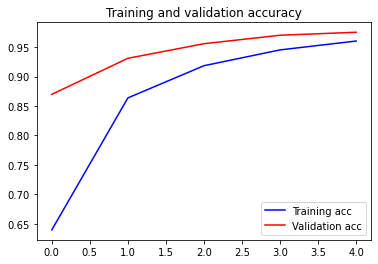

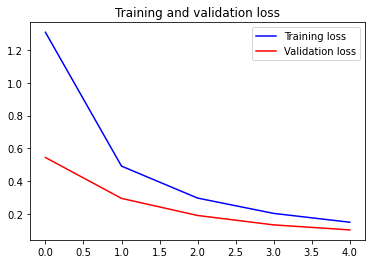

In [9]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(model_hist)

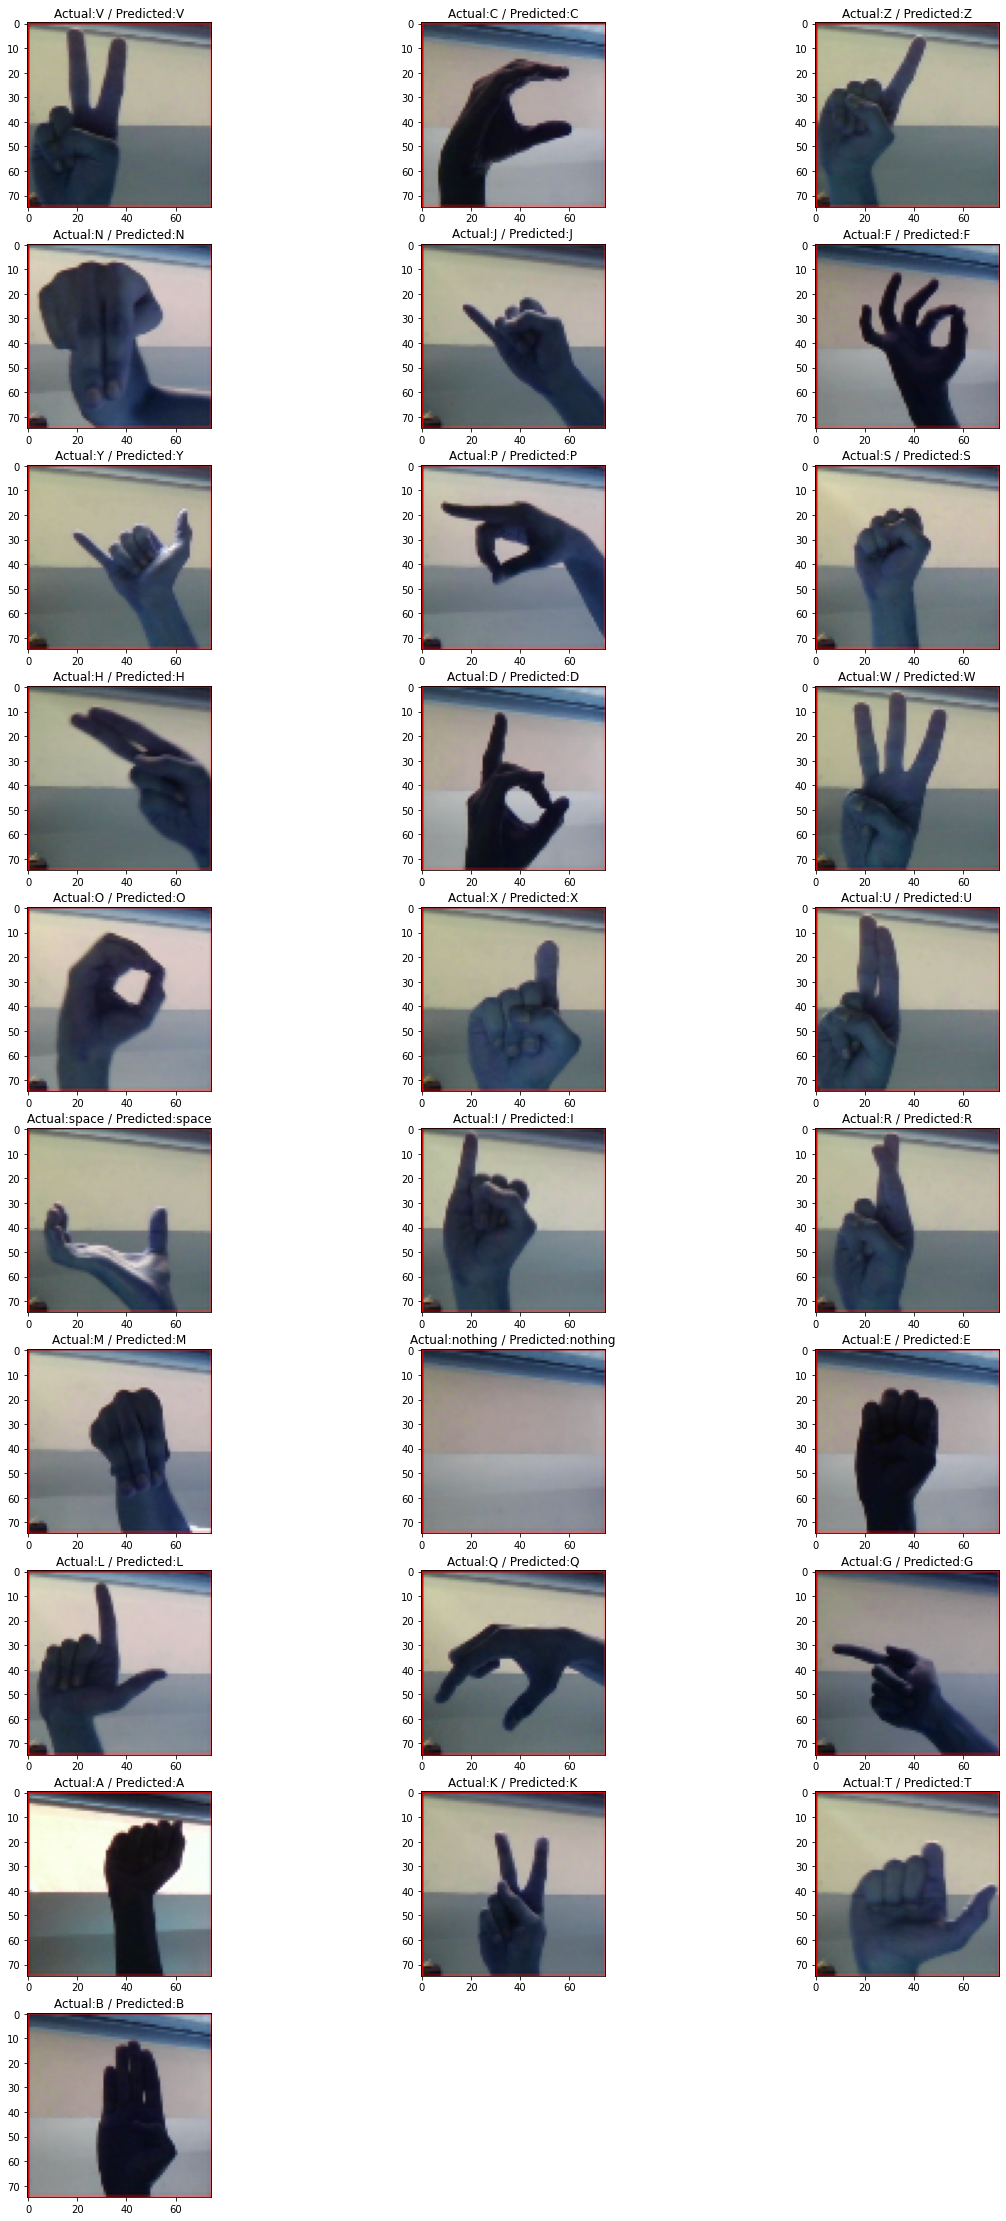

In [10]:
from PIL import Image

labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

inv_labels_dict = {v: k for k, v in labels_dict.items()}

size_img = 75,75            
plt.figure(figsize=(20,40))
for i in enumerate(os.listdir(test_dir)):
    image = cv2.imread(test_dir+'/'+i[1])
    image = np.asarray(image)
    image = image/255
    image = cv2.resize(image, size_img)
    
    plt.subplot(10,3,i[0]+1)
    plt.imshow(image)
    pred = np.argmax(model.predict(image.reshape(-1,75,75,3)))
    #print(pred, i[1])
    prediction = -1
    for j in range(29):
        if inv_labels_dict[pred] == inv_labels_dict[j]:
            prediction=inv_labels_dict[pred]
        else:
            continue       
    plt.title('Actual:{0} / Predicted:{1}'.format(i[1].split('_')[0],prediction))
    
plt.show()    
    #pred = np.argmax(model.predict(image.reshape(-1,200,200,3)))
    #for j in train.class_indices:
    #    if pred == train.class_indices[j]:
    #        prediction=j
    #    else:
    #        continue
    
    #plt.title('Actual:{0} / Predicted:{1}'.format(i[1],prediction))

In [11]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [14]:
print(yhat_probs.shape, yhat_classes.shape)
print(yhat_probs.shape, yhat_classes.shape, Y_test.shape)

Y_class = np.argmax(Y_test, axis=1)
print(Y_class[:5], yhat_classes[:5])

(4350, 29) (4350,)
(4350, 29) (4350,) (4350, 29)
[19 23 10 15  6] [19 23 10 15  6]


In [21]:
temp = Y_test[:,0]


temp1 = yhat_classes == clsi
print(temp.shape, temp1.shape)

(4350,) (4350,)


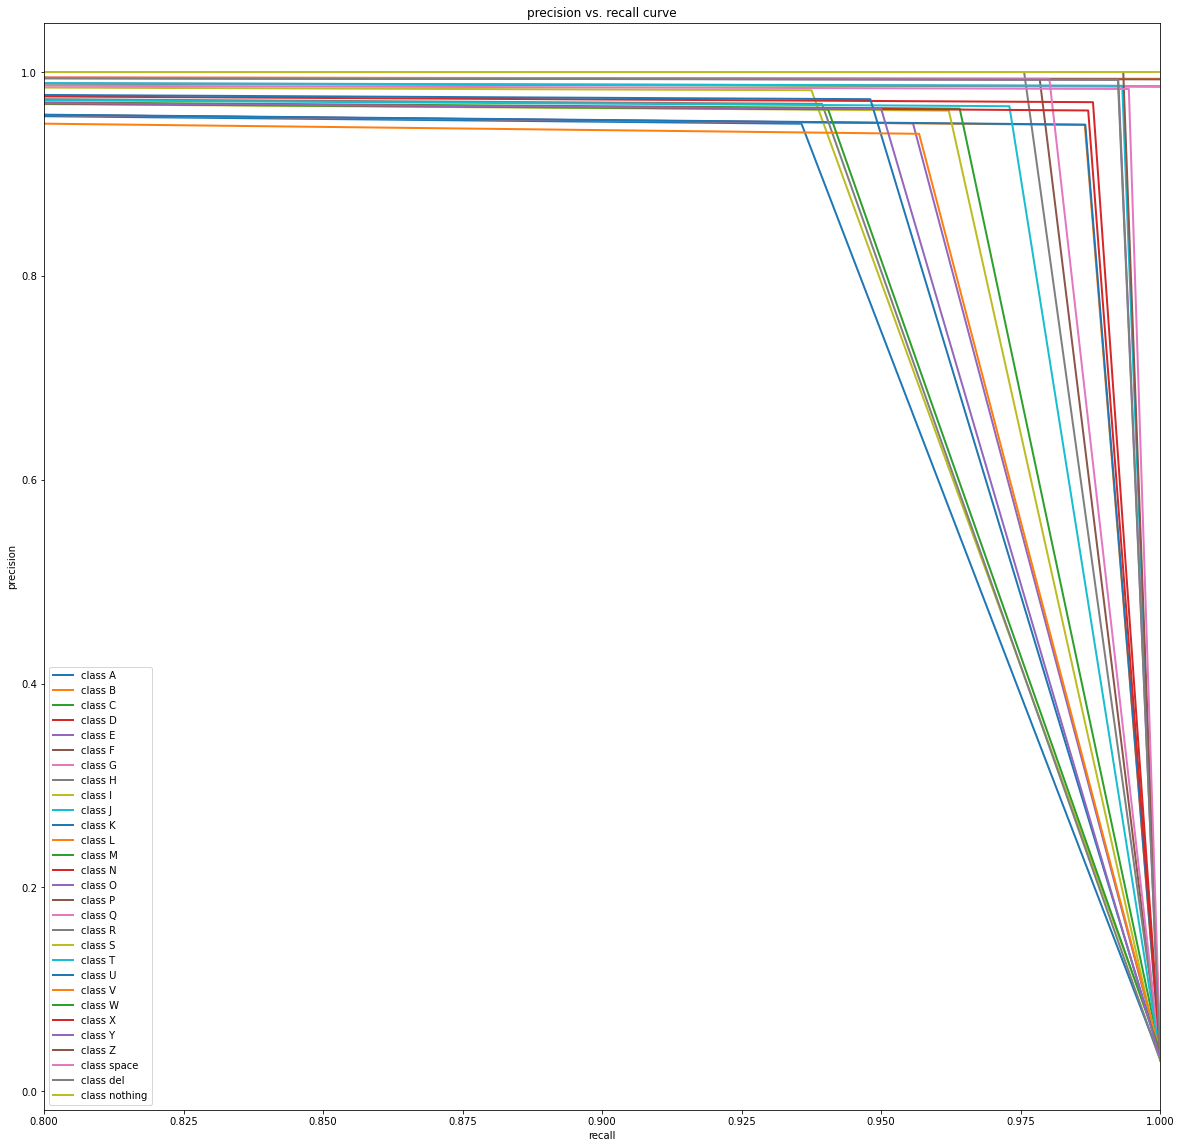

In [39]:
from sklearn.metrics import precision_recall_curve, roc_curve
precision = dict()
recall = dict()
plt.figure(figsize=(20, 20))
for clsi in range(29):
    precision[clsi], recall[clsi], _ = precision_recall_curve(Y_test[:,clsi], yhat_classes == clsi)
    plt.plot(recall[clsi], precision[clsi], lw=2, label='class {}'.format(inv_labels_dict[clsi]))

plt.xlim(0.8, 1.0) 
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

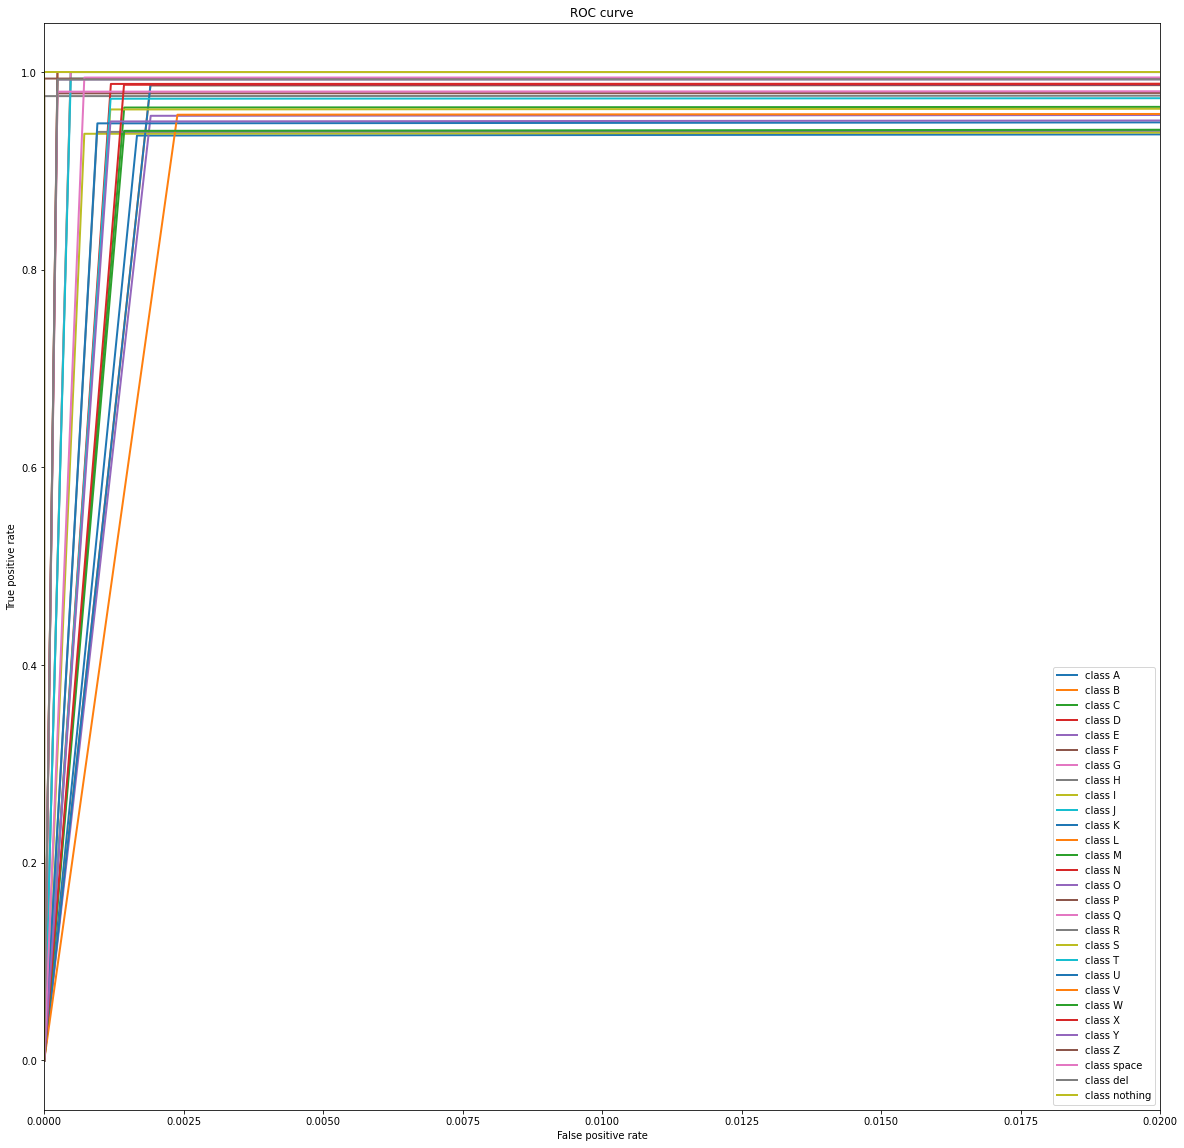

In [40]:
fpr = dict()
tpr = dict()
plt.figure(figsize=(20,20))
for clsi in range(29):
    fpr[clsi], tpr[clsi], _ = roc_curve(Y_test[:,clsi], yhat_classes == clsi)
    plt.plot(fpr[clsi], tpr[clsi], lw=2, label='class {}'.format(inv_labels_dict[clsi]))
plt.xlim(0.0, 0.02)  
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

for clsi in range(29):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(Y_test[:,clsi], yhat_classes == clsi)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(Y_test[:,clsi], yhat_classes == clsi, average='weighted')
    print('Label: %s' % inv_labels_dict[clsi],'Accuracy: %f' % accuracy, 'F1 score: %f' % f1)


Label: A Accuracy: 0.996322 F1 score: 0.996309
Label: B Accuracy: 0.997701 F1 score: 0.997723
Label: C Accuracy: 0.999540 F1 score: 0.999542
Label: D Accuracy: 1.000000 F1 score: 1.000000
Label: E Accuracy: 0.996552 F1 score: 0.996557
Label: F Accuracy: 0.999080 F1 score: 0.999077
Label: G Accuracy: 0.999540 F1 score: 0.999542
Label: H Accuracy: 0.999080 F1 score: 0.999075
Label: I Accuracy: 0.996782 F1 score: 0.996746
Label: J Accuracy: 0.999310 F1 score: 0.999311
Label: K Accuracy: 0.997701 F1 score: 0.997723
Label: L Accuracy: 0.999770 F1 score: 0.999770
Label: M Accuracy: 0.997241 F1 score: 0.997241
Label: N Accuracy: 0.998391 F1 score: 0.998398
Label: O Accuracy: 0.999540 F1 score: 0.999540
Label: P Accuracy: 0.999770 F1 score: 0.999771
Label: Q Accuracy: 0.999080 F1 score: 0.999078
Label: R Accuracy: 0.997241 F1 score: 0.997221
Label: S Accuracy: 0.997701 F1 score: 0.997701
Label: T Accuracy: 0.997931 F1 score: 0.997934
Label: U Accuracy: 0.997241 F1 score: 0.997224
Label: V Accu

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), yhat_classes)
#print(np.argmax(Y_test, axis=1).shape, yhat_classes.shape)
#print(np.argmax(Y_test, axis=1)[:5], yhat_classes[:5])
cm.shape

(29, 29)

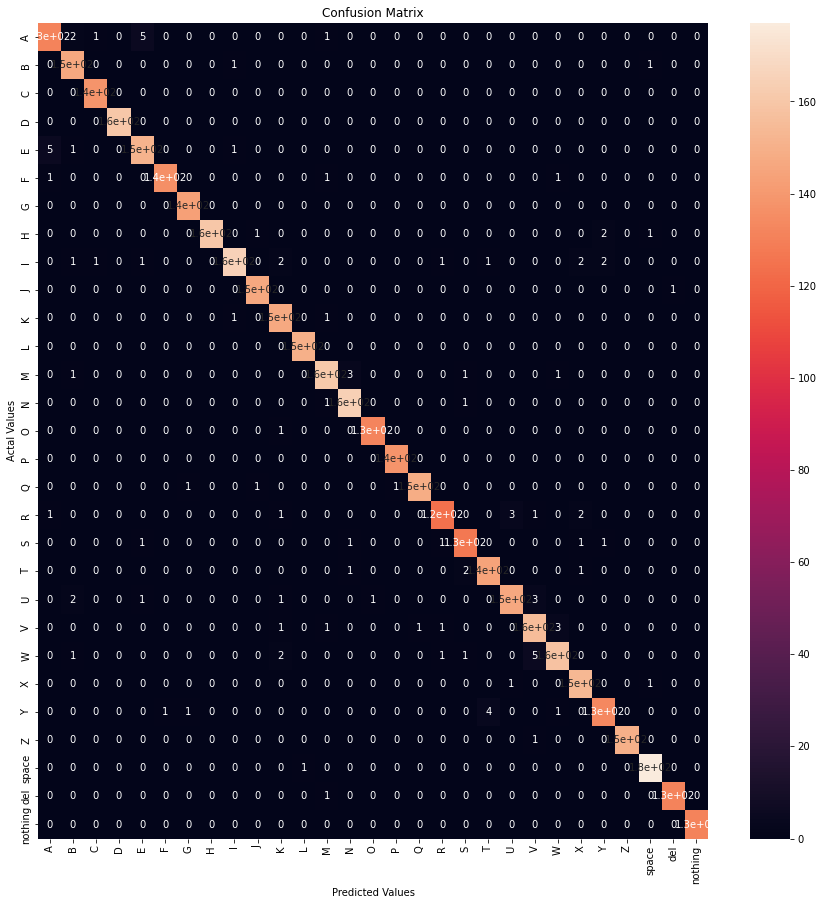

In [52]:
labels = [inv_labels_dict[i] for i in range(29)]

cm_df = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)

plt.figure(figsize=(15,15))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()